### Imports

In [89]:
from IPython import display

import cv2
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [90]:
gpus = tf.config.list_physical_devices('GPU')
print("GPU Available:", gpus)
print("cuDNN Enabled:", tf.test.is_built_with_cuda())

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Set the number of intra-op and inter-op threads
NUM_CORES = 8
tf.config.threading.set_intra_op_parallelism_threads(NUM_CORES)
tf.config.threading.set_inter_op_parallelism_threads(NUM_CORES)

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
cuDNN Enabled: True


### Definitions

In [91]:
train_size = 60000
batch_size = 32
test_size = 10000
# Path to your images folder
IMAGES_PATH = "/home/nicolas/Documentos/UTN/INA/giar_ina_dev/media/cropped_images/classification/train"
INPUT_SHAPE = 200

### Functions

In [92]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], INPUT_SHAPE, INPUT_SHAPE, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

### Get train data

In [93]:

# (train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

# train_images = preprocess_images(train_images)
# test_images = preprocess_images(test_images)

In [94]:
# # Load all image file paths
# image_files = [os.path.join(IMAGES_PATH,image) for image in os.listdir(IMAGES_PATH)]
# print(image_files)
# # Load and preprocess images
# def load_and_preprocess_image(path):
#     img = Image.open(path).convert('L')  # 'L' for grayscale, use 'RGB' if needed
#     img = img.resize((128, 128))           # Resize to 28x28 to match MNIST
#     img = np.array(img) / 255.0
#     # img = np.where(img > .5, 1.0, 0.0).astype('float32')
#     img = img.reshape((128, 128, 1))

#     # img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#     # img = cv2.resize(img, (128, 128))
#     # img = np.array(img) / 255.0
#     # img = img.reshape((128, 128, 1))
#     return img
        

# all_images = np.array([load_and_preprocess_image(p) for p in tqdm(image_files)])

# # Split into train and test sets (e.g., 80% train, 20% test)
# train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)

# print(train_images.shape, test_images.shape)

In [95]:
# train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
#                  .shuffle(train_size).batch(batch_size))
# test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
#                 .shuffle(test_size).batch(batch_size))

In [96]:
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split

# List all image file paths
image_files = [os.path.join(IMAGES_PATH, image) for image in os.listdir(IMAGES_PATH)]

# Split file paths into train and test
train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)

def load_and_preprocess_image_tf(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=1, expand_animations=False)
    image.set_shape([None, None, 1])  # Explicitly set shape for resizing
    # image = tf.image.resize(image, [INPUT_SHAPE, INPUT_SHAPE])
    image = tf.cast(image, tf.float32) / 255.0
    return image

def make_dataset(file_list, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(file_list)
    ds = ds.map(load_and_preprocess_image_tf, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

batch_size = 32
train_dataset = make_dataset(train_files, batch_size)
test_dataset = make_dataset(test_files, batch_size)

### Definition of the model

In [ ]:
kernel_size = (4,4)
filter = 32

class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    # self.encoder = tf.keras.Sequential(
    #     [
    #         tf.keras.layers.InputLayer(input_shape=(INPUT_SHAPE, INPUT_SHAPE, 1)),
    #         tf.keras.layers.Conv2D(filter, kernel_size, activation='relu', padding='same'),
    #         tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
    #         tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
    #         tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=(2, 2), activation='relu'),
    #         # tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=(2, 2), activation='relu'),
    #         # tf.keras.layers.Conv2D(filter//2, kernel_size, activation='relu', padding='same'),
    #         # tf.keras.layers.Conv2D(filter//4, kernel_size, activation='relu', padding='same'),
    #         # tf.keras.layers.Conv2D(filter//8, kernel_size, activation='relu', padding='same'),
    #         # tf.keras.layers.Conv2D(filter//16, kernel_size, activation='relu', padding='same'),

    #         tf.keras.layers.Flatten(),
    #         tf.keras.layers.Dense(latent_dim + latent_dim),
    #     ]
    # )

    # self.decoder = tf.keras.Sequential(
    #     [
    #       tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
    #       tf.keras.layers.Dense(units=7*7*64, activation=tf.nn.relu),
    #       tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    #       tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),   # 7x7 -> 14x14
    #       tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),   # 14x14 -> 28x28
    #       tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu'),   # 28x28 -> 56x56
    #       tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same', activation='relu'),    # 56x56 -> 112x112
    #       tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same', activation=None),      # 112x112 -> 224x224
    #       tf.keras.layers.Cropping2D(((12,12),(12,12))),  # 224x224 -> 200x200


    #       # tf.keras.layers.Dense(units=8*8*512, activation=tf.nn.relu),
    #       # tf.keras.layers.Reshape(target_shape=(8, 8, 512)),
    #       # tf.keras.layers.Conv2DTranspose(filter//16, kernel_size, strides=2, activation='relu', padding='same'), # 4 -> 8
    #       # tf.keras.layers.Conv2DTranspose(filter//8, kernel_size, strides=2, activation='relu', padding='same'), # 8 -> 16
    #       # tf.keras.layers.Conv2DTranspose(filter//4, kernel_size, strides=2, activation='relu', padding='same'),  # 16 -> 32
    #       # tf.keras.layers.Conv2DTranspose(filter//2, kernel_size, strides=2, activation='relu', padding='same'),  # 32 -> 64
    #       # tf.keras.layers.Conv2DTranspose(filter, kernel_size, strides=2, activation='relu', padding='same'),  # 64 -> 128
    #       # tf.keras.layers.Conv2DTranspose(1, kernel_size, strides=1, activation=None, padding='same')
    #     ]
    # )

    # --- ENCODER ---
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(INPUT_SHAPE, INPUT_SHAPE, 1)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=(2, 2), activation='relu', padding='same'), # 200x200 -> 100x100
            tf.keras.layers.BatchNormalization(),

            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu', padding='same'), # 100x100 -> 50x50
            tf.keras.layers.BatchNormalization(),

            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2, 2), activation='relu', padding='same'), # 50x50 -> 25x25
            tf.keras.layers.BatchNormalization(),
            
            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2, 2), activation='relu', padding='same'), 
            tf.keras.layers.BatchNormalization(),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    # --- DECODER ---
    self.decoder = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=13*13*256, activation=tf.nn.relu), 
          tf.keras.layers.Reshape(target_shape=(13, 13, 256)),
          tf.keras.layers.BatchNormalization(),

          tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu'), # 13x13 -> 26x26
          tf.keras.layers.BatchNormalization(),

          tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),   # 26x26 -> 52x52
          tf.keras.layers.BatchNormalization(),

          tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),   # 52x52 -> 104x104
          tf.keras.layers.BatchNormalization(),
          
          tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu'),   # 104x104 -> 208x208
          tf.keras.layers.BatchNormalization(),

          tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation=None), # 208x208 -> 208x208
          
          tf.keras.layers.Cropping2D(((4,4),(4,4))), 
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

### Loss definitions

Funcion de perdida total:
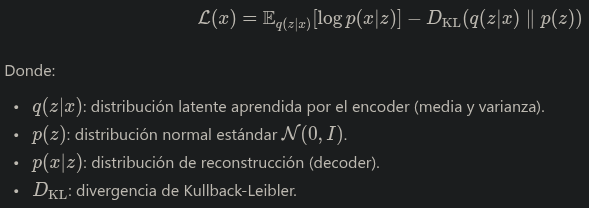


Referencia 1
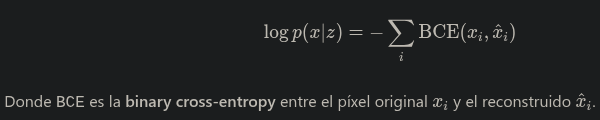


Referencia 2
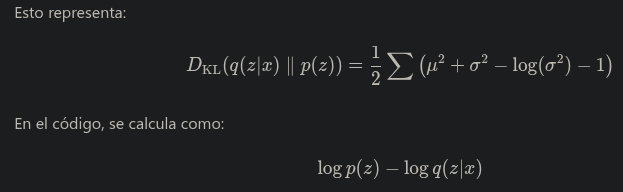

logpz: la probabilidad de que z venga de una normal estándar.
logqz_x: la probabilidad de que z venga de la distribución aprendida por el encoder.

Referencia 3:
log_normal_pdf calcula logaritmo de la densidad de probabilidad de una distribución normal multivariada. Se usa para:
Fórmula:
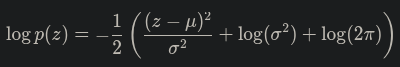


In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)

#Referencia 3
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)
#logvar es log(σ²), por eso se usa tf.exp(-logvar) para obtener 1/σ².

class CustomLoss(tf.keras.losses.Loss):
    def __init__(self, y, z, name="custom_loss"):
        super().__init__(name=name)
        # Weights
        self.y = y
        self.z = z

        # MAE
        self.mae_loss_fn = tf.keras.losses.MeanAbsoluteError()

    # SSIM loss
    def ssim_loss(self, y_true, y_pred):
        ssim = (1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))) / 2
        return ssim

    def call(self, y_true, y_pred):
        mae_loss = self.mae_loss_fn(y_true, y_pred)
        ssim = self.ssim_loss(y_true, y_pred)
        return self.y * mae_loss + self.z * ssim

# Instancia de CustomLoss
custom_loss_fn = CustomLoss(y=0.5, z=0.5)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    # Referencia 1: diferencia entre la reconstrucción y la entrada original usando CustomLoss
    # reconstruction_loss = custom_loss_fn(x, x_logit)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    reconstruction_loss = tf.reduce_sum(cross_ent, axis=[1, 2, 3])

    # Referencia 2: divergencia KL entre la distribución latente y una normal estándar
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    kl_divergence = logqz_x - logpz

    total_loss = tf.reduce_mean(reconstruction_loss + kl_divergence)
    return total_loss, tf.reduce_mean(reconstruction_loss), tf.reduce_mean(kl_divergence)

@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [99]:
epochs = 20
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 128
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [100]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(6, 6))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [101]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 1, Test set ELBO: -0.19252175092697144, time elapse for current epoch: 33.11332631111145


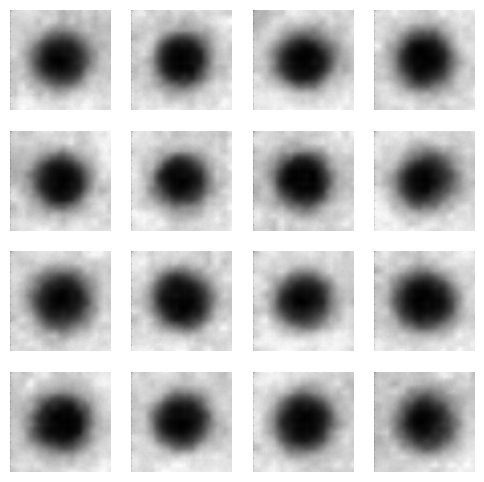

KeyboardInterrupt: 

In [102]:
elbo_values = []
reconstruction_losses = []
kl_divergences = []

generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
      train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  reconstruction_loss = tf.keras.metrics.Mean()
  kl_divergence = tf.keras.metrics.Mean()
  
  for test_x in test_dataset:
      total_loss, rec_loss, kl_div = compute_loss(model, test_x)
      loss(total_loss)
      reconstruction_loss(rec_loss)
      kl_divergence(kl_div)
  
  elbo = -loss.result()
  elbo_values.append(elbo.numpy())
  reconstruction_losses.append(reconstruction_loss.result().numpy())
  kl_divergences.append(kl_divergence.result().numpy())

  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)


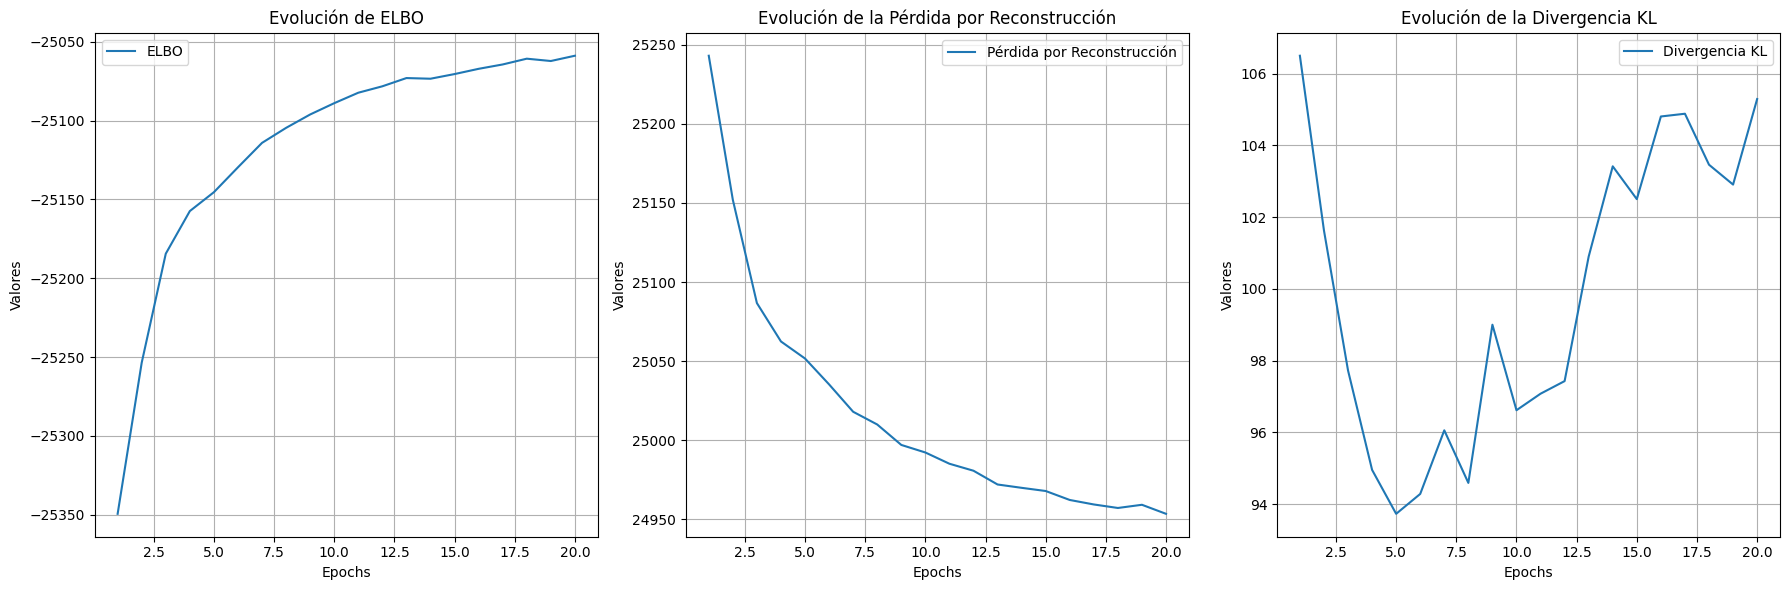

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Subplot 1: ELBO
axs[0].plot(epochs_range, elbo_values, label='ELBO')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Valores')
axs[0].set_title('Evolución de ELBO')
axs[0].legend()
axs[0].grid(True)

# Subplot 2: Pérdida por Reconstrucción
axs[1].plot(epochs_range, reconstruction_losses, label='Pérdida por Reconstrucción')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Valores')
axs[1].set_title('Evolución de la Pérdida por Reconstrucción')
axs[1].legend()
axs[1].grid(True)

# Subplot 3: Divergencia KL
axs[2].plot(epochs_range, kl_divergences, label='Divergencia KL')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Valores')
axs[2].set_title('Evolución de la Divergencia KL')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(np.float64(-0.5), np.float64(599.5), np.float64(599.5), np.float64(-0.5))

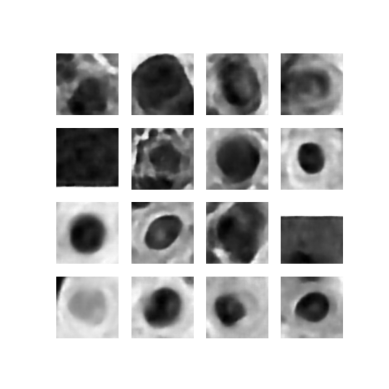

In [ ]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

In [ ]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

/tmp/ipykernel_14117/1290275450.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipykernel_14117/1290275450.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



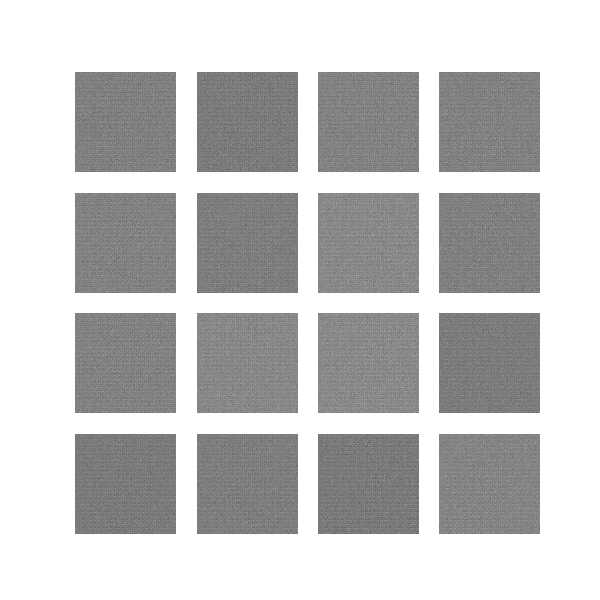

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [ ]:
def plot_latent_images(model, n, digit_size=128):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

In [ ]:
plot_latent_images(model, 20)

ValueError: in user code:

    File "/tmp/ipykernel_14117/766230859.py", line 116, in sample  *
        return self.decode(eps, apply_sigmoid=True)
    File "/tmp/ipykernel_14117/766230859.py", line 127, in decode  *
        logits = self.decoder(z)
    File "/home/nicolas/Documentos/UTN/INA/giar_ina_dev/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/home/nicolas/Documentos/UTN/INA/giar_ina_dev/.venv/lib/python3.12/site-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling Sequential.call().
    
    [1mInput 0 of layer "dense_9" is incompatible with the layer: expected axis -1 of input shape to have value 128, but received input with shape (1, 2)[0m
    
    Arguments received by Sequential.call():
      • inputs=tf.Tensor(shape=(1, 2), dtype=float32)
      • training=None
      • mask=None
      • kwargs=<class 'inspect._empty'>
